In [2]:
!pip install evaluate
%pip install transformer_lens
%pip install torchtyping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 19.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.8 MB/s eta 0:00:00
   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/797.1 MB 108.0 MB/s eta 0:00:07
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from datasets import load_dataset
import evaluate
import pandas as pd
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class InferenceModel:
    def __init__(self, model_name, device):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", offload_buffers=True)
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        self.model.eval()
        self.logits = []
    
    def init_eval(self):
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        
    def get_logprobs(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        outputs = self.model(**inputs, output_hidden_states=True)
        logits = outputs.logits
        # Shape remains, but values are now normalized as log probabilities over the vocabulary.
        logprobs = torch.gather(F.log_softmax(logits, dim=2), 2, output_ids.unsqueeze(2))
        return logprobs, outputs
        
    def inference(self, prompt):
        """
        Performs inference on a given prompt.
        Returns the decodede output
        """
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        output = self.model.generate(
            **inputs, 
            do_sample=False,
            temperature=None,
            top_p=None,
            top_k=None,
            max_new_tokens=1)
        # print(f"output: {output}")
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output)
        ]
        generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        self.answers.append(generated_text)
        # answer = "1" if "option1" in generated_text else "2" if "option2" in generated_text else None
        
        return generated_text

    def batch_inference(self, prompts):
        """
        Perform batch inference.
        """
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=50)
        generated_texts = []
        for input_ids, output_ids in zip(inputs.input_ids, outputs):
            generated_ids = [
                output_ids[len(input_ids):]
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            generated_texts.append(generated_text)
        self.answers.extend(generated_texts)
        return generated_texts

    def eval(self):
        """
        Evaluates the predictions against the references 
        """
        accuracy_results = self.acc_metric.compute(predictions=self.predictions, references=self.references)

        precision_results = self.precision_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        recall_results = self.recall_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        results = {
            'acc' : accuracy_results,
            'prec' : precision_results,
            'recall' : recall_results
        }
        self.eval_results.append(results)
        print("Evaluation Results:\n", results)
        return results

    
    def parse_save_output(self, generated_text, unique_labels, current_labeltexts, currentlabel):
        """
        generated_text: output from model.generate (e.g. '1', 'option 1', 'anna')
        unique_labels: unique labels from dataset (list of string e.g. ["1", "2"])
        current_labeltexts: the current label options (dict of current label text e.g. {1:'anna', 2:'susan'})
        currentlabel = the current reference label from dataset (string, the dataset['answer']. e.g. "2", "1" )
        """
        pred = None
        clean_generated_text = generated_text.lower().strip()
        for i in unique_labels:
            if str(i) in clean_generated_text or current_labeltexts[int(i)].lower().strip() in clean_generated_text or current_labeltexts[int(i)].lower().removeprefix("the").strip() in clean_generated_text :
                pred = i
                break
        # print(f"gt: {generated_text}")
        # print(f"pred : {pred}")
        if pred == None:
            pred = "9"
        self.predictions.append(pred)
        self.references.append(currentlabel)
        ans_dict = ({'pred_answer':pred, 'pred_answertext' : generated_text})
        # print(f"ans_dict {ans_dict}")
        self.df.loc[len(self.df)] = ans_dict
        return pred



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:

massive_qwen = InferenceModel("Qwen/Qwen2.5-0.5B-Instruct", device)
# xwinograd_bloomz = InferenceModel("bigscience/bloomz-560m", device)
# xnli_qwen = InferenceModel("Qwen/Qwen2.5-0.5B-Instruct", device)
# xnli_bloomz = InferenceModel("bigscience/bloomz-560m", device)


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [6]:
massive_qwen.model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

The neurons we're interested is in act_fn in Qwen2MLP

In [7]:
from datasets import load_dataset

ds = load_dataset("AmazonScience/massive", "af-ZA")

README.md:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

massive.py:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

af-ZA/train/0000.parquet:   0%|          | 0.00/785k [00:00<?, ?B/s]

af-ZA/validation/0000.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

af-ZA/test/0000.parquet:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

In [8]:
"all".startswith("all")

True

In [ ]:
# import torch 
# from datasets import get_dataset_config_names
# from tqdm import tqdm

# def inference_xwinograd(model_name, infer_model):
#     eval_result = {}
#     dataset_name = "AmazonScience/massive"
#     configs = get_dataset_config_names(dataset_name)
#     for lang in configs if not lang.startswith("all") :
#         ds = load_dataset(dataset_name, lang, split="test")
#         for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
#             # print(data)
#             current_labeltexts = {1:data['option1'], 2:data['option2']}
#             prompt = (
#                     f"{data['sentence']}\n"
#                     # f"Does _ refer to {current_labeltexts[2]}? True or False?"
#                     f"Who does '_' refer to? The answer should be one of '1: {current_labeltexts[1]}' or '2: {current_labeltexts[2]}'.\n"
#                     f"Answer:"
            
#                 )
#             # print(prompt)
#             generated_text = infer_model.inference(prompt)
#             # print(f"gen_text {generated_text}")
#             answer = generated_text.split()[0]
#             print(generated_text)
            
#             pred = infer_model.parse_save_output(
#                 generated_text, 
#                 ds['answer'], 
#                 current_labeltexts, 
#                 data['answer'])
#             break # one sample
        
#         evaluated = infer_model.eval()
#         eval_result[lang] = evaluated
#         print(f"Done with lang: {lang}")
#         break # one language
#     infer_model.df.to_csv(f"out_{model_name.split('/')[-1]}_{dataset_name.split('/')[-1]}", index=False)
#     return eval_result


In [15]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm

eval_result = {}
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name)
for lang in [lang for lang in configs if not lang.startswith("all")]:
    ds = load_dataset(dataset_name, lang, split="test")
    for data in (ds):
        print(data)
        break
    break
        

{'id': '0', 'locale': 'af-ZA', 'partition': 'test', 'scenario': 16, 'intent': 48, 'utt': 'maak my wakker om vyf v. m. die week', 'annot_utt': 'maak my wakker om [time : vyf v. m.] [date : die week]', 'worker_id': '37', 'slot_method': {'slot': ['time', 'date'], 'method': ['localization', 'translation']}, 'judgments': {'worker_id': ['20', '40', '64'], 'intent_score': [1, 1, 1], 'slots_score': [1, 1, 1], 'grammar_score': [4, 4, 4], 'spelling_score': [2, 2, 1], 'language_identification': ['target', 'target', 'target']}}


In [7]:
infer_model = massive_qwen
for i in range(len(infer_model.model.model.layers)):
    mlp = infer_model.model.model.layers[i].mlp
    mlp.act_fn._forward_hooks.clear()
    mlp.gate_proj._forward_hooks.clear()
    mlp.up_proj._forward_hooks.clear()


### cek apakah output act_fn == output Act_function(first linear transformation)

alternatif lain bisa pake:
- transformerlens
- override method forward langsung di model (ini lebih cepat katanya)

In [9]:
layer_outputs = {}

def get_activation(name): # biar ada namanya
    def hook_fn(module, input, output):
        # `output` is the result after the activation function
        print(f"Layer: {name}, output Shape: {output.shape}")
        print("Output", output)
        layer_outputs[name] = output
    return hook_fn


#### 1. pake hook langsung di act_fn

In [131]:
infer_model = massive_qwen

eval_result = {}
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name)
for lang in [lang for lang in configs if not lang.startswith("all")]:
    ds = load_dataset(dataset_name, lang, split="test")
    for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
        
        # Assuming `model` is your Qwen2ForCausalLM instance
        layer_index = 1  # or any layer you are interested in
        mlp = infer_model.model.model.layers[layer_index].mlp
        mlp.act_fn._forward_hooks.clear()
        # Register the hook on the activation function
        handle = mlp.act_fn.register_forward_hook(get_activation("mlp1_act_fn"))
        print(f"data: {data['utt']}")
        # Forward pass through the model
        prompt = (
                f"{data['utt']}"
            )
        # print(prompt)
        generated_text = infer_model.inference(prompt)
        # Remove the hook when done
        handle.remove()
        
        # print(f"gen_text {generated_text}")
       
        break # one sample
    
    print(f"Done with lang: {lang}")
    break # 

data: maak my wakker om vyf v. m. die week
Layer: mlp1_act_fn, output Shape: torch.Size([1, 15, 4864])
Output tensor([[[-0.2200, -0.2780, -0.0797,  ...,  0.2259, -0.0492, -0.2783],
         [-0.2672, -0.2161, -0.0416,  ...,  0.1205, -0.1830,  0.0184],
         [ 0.3361, -0.2575, -0.0783,  ..., -0.2051, -0.2675, -0.2664],
         ...,
         [ 0.2957, -0.2782, -0.0507,  ...,  0.0811, -0.0333, -0.2753],
         [ 0.0134, -0.2242,  0.1403,  ..., -0.2170, -0.2511, -0.2737],
         [ 0.2627, -0.1525, -0.1808,  ..., -0.2394, -0.0415, -0.2748]]],
       device='cuda:0')
Done with lang: af-ZA


#### 2. hitung sendiri act_fn di output linear transformation pertama 

In [133]:
infer_model = massive_qwen
eval_result = {}
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name)
for lang in [lang for lang in configs if not lang.startswith("all")]:
    ds = load_dataset(dataset_name, lang, split="test")
    for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
        
        layer_index = 1  # or any layer you are interested in
        mlp = infer_model.model.model.layers[layer_index].mlp
        mlp.act_fn._forward_hooks.clear()
        # Register the hook on the activation function
        handle = mlp.gate_proj.register_forward_hook(get_activation("mlp1_gate_proj"))
        handle2 = mlp.up_proj.register_forward_hook(get_activation("mlp1_up_proj"))

        # register all callback hook functions
        handlers = [handle, handle2]
        print(f"data: {data['utt']}")
        # Forward pass through the model
        prompt = (
                f"{data['utt']}"
            )
        # print(prompt)

        # inputs = infer_model.tokenizer(prompt, return_tensors="pt").to(infer_model.model.device)
        
        # Generate output
        # output = self.model.generate(
        #     **inputs, 
        #     do_sample=False,
        #     temperature=None,
        #     top_p=None,
        #     top_k=None,
        #     max_new_tokens=1
        # )

        # output = infer_model.model.generate(**inputs, max_new_tokens=1)  # Force no caching
        generated_text = infer_model.inference(prompt)
        
        # outputs = infer_model.model(**inputs)
        # logits = outputs.logits  # Shape: [batch_size, seq_len, vocab_size]
        
        # # Get the last token's logits (the next predicted token)
        # next_token = logits[:, -1, :].argmax(dim=-1)  # Take the most probable token
        # Remove the hook when done
        for i in handlers:
            i.remove()
        
        # print(f"gen_text {generated_text}")
       
        break # one sample
    
    print(f"Done with lang: {lang}")
    break # 

data: maak my wakker om vyf v. m. die week
Layer: mlp1_gate_proj, output Shape: torch.Size([1, 15, 4864])
Output tensor([[[-0.6352, -1.2145, -0.1746,  ...,  0.3804, -0.1038, -1.3209],
         [-0.9765, -0.6163, -0.0870,  ...,  0.2175, -0.4781,  0.0362],
         [ 0.5332, -0.8758, -0.1713,  ..., -0.5665, -0.9804, -0.9670],
         ...,
         [ 0.4789, -1.2289, -0.1071,  ...,  0.1508, -0.0691, -1.1138],
         [ 0.0264, -0.6563,  0.2496,  ..., -0.6205, -1.8534, -1.4989],
         [ 0.4331, -0.3743, -0.4702,  ..., -0.7424, -0.0868, -1.4712]]],
       device='cuda:0')
Layer: mlp1_up_proj, output Shape: torch.Size([1, 15, 4864])
Output tensor([[[-0.7753, -0.5051,  0.1669,  ...,  0.8807,  0.2014, -0.2443],
         [ 0.0411, -0.3244,  0.0091,  ...,  0.2595,  0.6894,  0.7306],
         [ 0.3624,  0.0466, -0.4368,  ...,  0.1667,  0.0335, -0.3440],
         ...,
         [ 0.6712, -0.4245,  0.0857,  ...,  0.3670,  0.3262,  0.3288],
         [-0.1185,  0.1655,  0.2573,  ...,  0.4110,  0.

In [105]:
infer_model.tokenizer.bos_token_id # gaada

In [136]:
layer_outputs['mlp1_gate_proj'].shape

torch.Size([1, 15, 4864])

In [49]:
torch.nn.SiLU()

SiLU()

In [56]:
activation = nn.SiLU()  # Create an instance
activation(layer_outputs['mlp1_gate_proj'])  # Apply it to the tensor


tensor([[[-0.0968, -0.2006,  0.3872,  ...,  0.0117, -0.2499, -0.2647],
         [-0.1168, -0.2624,  0.3224,  ...,  0.1731,  0.1985, -0.2622],
         [-0.2417, -0.2147,  0.2050,  ...,  0.2737, -0.1611, -0.0294],
         ...,
         [-0.1356, -0.2709, -0.0119,  ..., -0.0455, -0.1010, -0.2117],
         [ 0.0991, -0.0921,  0.2615,  ..., -0.2462, -0.0471, -0.0277],
         [ 0.1501, -0.2488,  0.1197,  ...,  0.1976, -0.1996, -0.1625]]],
       device='cuda:0')

In [139]:
import torch.nn.functional as F

manual_silu_output = F.silu(layer_outputs['mlp1_gate_proj'])  # Correct way
manual_silu_output

tensor([[[-0.2200, -0.2780, -0.0797,  ...,  0.2259, -0.0492, -0.2783],
         [-0.2672, -0.2161, -0.0416,  ...,  0.1205, -0.1830,  0.0184],
         [ 0.3361, -0.2575, -0.0783,  ..., -0.2051, -0.2675, -0.2664],
         ...,
         [ 0.2957, -0.2782, -0.0507,  ...,  0.0811, -0.0333, -0.2753],
         [ 0.0134, -0.2242,  0.1403,  ..., -0.2170, -0.2511, -0.2737],
         [ 0.2627, -0.1525, -0.1808,  ..., -0.2394, -0.0415, -0.2748]]],
       device='cuda:0')

In [138]:
torch.allclose(layer_outputs['mlp1_act_fn'], manual_silu_output, atol=1e-5)


True

SAMA!!!

#### 3. pake transformerlens

beda, mungkin karena beda cara generatenya, atau karena ada prepend_bos nya

In [66]:
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

In [67]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "Qwen/Qwen2.5-0.5B", device=device
)

# Get the default device used
device: torch.device = utils.get_device()

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer


In [70]:
example_prompt = ["maak my wakker om vyf v. m. die week."]
example_answer = " "
utils.test_prompt(example_prompt[0], example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'ma', 'ak', ' my', ' w', 'ak', 'ker', ' om', ' vy', 'f', ' v', '.', ' m', '.', ' die', ' week', '.']
Tokenized answer: [' ']


Performance on answer token:
Rank: 0        Logit: 13.77 Prob:  2.60% Token: | |

Top 0th token. Logit: 13.77 Prob:  2.60% Token: | |
Top 1th token. Logit: 13.71 Prob:  2.45% Token: |<|endoftext|>|
Top 2th token. Logit: 13.55 Prob:  2.07% Token: | 
|
Top 3th token. Logit: 13.46 Prob:  1.90% Token: | (|
Top 4th token. Logit: 13.35 Prob:  1.71% Token: | V|
Top 5th token. Logit: 13.29 Prob:  1.61% Token: | 

|
Top 6th token. Logit: 13.24 Prob:  1.53% Token: | Ik|
Top 7th token. Logit: 13.21 Prob:  1.48% Token: | -|
Top 8th token. Logit: 13.13 Prob:  1.37% Token: | I|
Top 9th token. Logit: 13.06 Prob:  1.27% Token: | De|


Ranks of the answer tokens: [(' ', 0)]

In [73]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-23): 24 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [10]:
from torchtyping import TensorType as TT


In [72]:
tokens = model.to_tokens(example_prompt, prepend_bos=True)
tokens

tensor([[151643,   1728,    585,    847,    289,    585,   7052,   7861,  45259,
             69,    348,     13,    296,     13,   2746,   2003,     13]],
       device='cuda:0')

In [92]:
def patch_resid(out: TT["batch", "pos", "d_model"], hook=None):
    # corrupted_resid[:, pos, :] = clean_cache[hook.name][:, pos, :]
    print(out)
    return out

In [98]:
patched_logits = model.run_with_hooks(
    tokens,
    fwd_hooks=[
        ("blocks.1.hook_mlp_out", patch_resid)
    ],
    return_type="none"
)


tensor([[[ 1.0535e-01,  2.1015e-01,  1.9084e-01,  ...,  1.7543e-01,
          -2.0344e-01,  4.4151e-01],
         [-9.0139e-02, -1.1863e-02,  1.7293e-01,  ..., -2.0146e-01,
          -1.0280e-01,  1.1439e-01],
         [ 1.6705e-01, -5.7129e-02, -5.6982e-02,  ...,  5.1725e-02,
           5.6933e-03,  1.8816e-01],
         ...,
         [-6.0515e-02, -2.3085e-01, -1.8566e-01,  ..., -3.2851e-02,
          -6.0347e-02,  1.2400e-01],
         [-2.4668e-01, -1.6782e-04,  1.0682e-01,  ...,  1.0031e-01,
          -1.2606e-02,  1.6048e-01],
         [ 1.1506e-02, -4.2615e-02,  3.9433e-02,  ...,  4.2605e-02,
          -7.2782e-03,  2.6309e-02]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


### masukin hasil inference ke tabel

In [8]:
infer_model = massive_qwen


- ada 2 dict untuk setiap language: 
-> *raw_values_avg_tokens* dan *raw_values_last_token*:

key-nya nama layer dari layer pertama sampe terakhir. setiap valuenya
ukurannya (num_row_in_dataset, hidden_dim) ini neuronnya bisa averaged tokens atau last token. output keluaran suatu neuron adlaah (batch_size, seq_len, num_neurons_di_suatu_layer) tapi seq_len menjadi 1 karena diambil averagenya (raw_values_avg_tokens) atau last token (raw_values_last_token) dari seq) sehingga (num_row_in_dataset, 1, hidden_dim) dijadiin (num_row_in_dataset, hidden_dim) aja.


- tensor *full_raw_values_avg_tokens* dan *full_raw_values_last_token*: adalah tensor dari raw_values_avg_tokens atau raw_values_last_token yang nyatuin semua neurons dari semua layer. ukurannya (batch_size, num_neurons_total_seluruh_layer)


- tensor *full_raw_values*: adalah tensor yang nyatuin full_raw_values_avg_tokens dan full_raw_values_last_token. ukurannya (2, batch_size, num_neurons_total_seluruh_layer). yg pertama full_raw_values_avg_tokens kedua full_raw_values_last_token.


### start playground

In [61]:
# IMP: ini buat nyatuin tiap entry di dataset
import torch

tensor1 = torch.randn(1, 2, 3)  # Shape: (1, 2, 3)
print(tensor1)
tensor2 = torch.randn(2, 2, 3)  # Shape: (2, 2, 3)
print(tensor2)
# Concatenate along dim=0
result = torch.cat([tensor1, tensor2], dim=0)

print(result.shape)  # Output: (3, 2, 3)


tensor([[[-0.3380, -0.4270, -0.4377],
         [ 1.3522, -1.5015, -0.1378]]])
tensor([[[ 1.0448,  1.8319,  0.7205],
         [-0.1121, -0.0309, -0.1503]],

        [[ 1.8928,  1.3067, -0.0662],
         [-0.4235, -2.3768,  0.0641]]])
torch.Size([3, 2, 3])


In [62]:
tensor2 = torch.tensor([[1, 2], [3, 4]])  # Shape: [1, 2]
# print(tensor2.float().mean(dim=1))
print(tensor2.float()[-1, :])

tensor([3., 4.])


In [99]:
tensor2 = torch.tensor([[1, 2], [3, 4]])  # Shape: [1, 2]
print(tensor2.shape)
lists = [tensor2, tensor2, tensor2]
stacked = torch.stack(lists, dim=0)
print(stacked.shape)

torch.Size([2, 2])
torch.Size([3, 2, 2])


In [64]:
raw_values_avg_tokens = {}
raw_values_last_token = {}
# ini yg raw value


# def aggregate_across_tokens(output, is_averaged_tokens):
#     if is_averaged_tokens:
#         output = output.float().mean(dim=1, keepdim=True) 
#     else:
#         output = output.float()[:, -1:] # get the last token
#     return output

def save_raw_vals_to_dict(name, dictname, savees):
    if not name in dictname:
        dictname[name] = savees
    else:
        dictname[name] = torch.cat([dictname[name], savees], dim=0)

def coba(name, is_averaged_tokens, output):
    # output is always (batch size, 1, hidden dim)
    # print(f"Layer: {name}, output Shape: {output.shape}")
    # print("Output", output)
    # output is always (batch size, hidden dim), where hidden dim is the number of neurons in a layer.
    output 
    if is_averaged_tokens: # simpen average value across tokens
        output = output.float().mean(dim=1) 
        save_raw_vals_to_dict(name, raw_values_avg_tokens, output)
    else:
        output = output.float()[-1,:] # simpen the last token
        save_raw_vals_to_dict(name, raw_values_last_token, output)
        
    

In [65]:
x = torch.tensor([[[1, 2], [3, 4]]])
y = torch.tensor([[[5, 6], [7, 8]]])
z = torch.tensor([[[1, 6], [3, 2]]])

# layer_outputs['a'] = x
coba("a", True, x)
coba("a", True, y)
print(raw_values_avg_tokens['a'])
print(raw_values_avg_tokens['a'].shape)

coba("a", False, y)
coba("a", False, z)
print(raw_values_last_token['a'])
print(raw_values_last_token['a'].shape)


tensor([[2., 3.],
        [6., 7.]])
torch.Size([2, 2])
tensor([[5., 6.],
        [7., 8.],
        [1., 6.],
        [3., 2.]])
torch.Size([4, 2])


In [17]:
x = torch.tensor([[[1, 2], [3, 4]]])
# layer_outputs['a'] = x
coba("b", True, y)
coba("b", True, y)
print(raw_values_avg_tokens['b'])
print(raw_values_avg_tokens['b'].shape)

coba("b", False, x)
coba("b", False, x)

print(raw_values_last_token['b'])
print(raw_values_last_token['b'].shape)


tensor([[6., 7.],
        [6., 7.]])
torch.Size([2, 2])
tensor([[3., 4.],
        [3., 4.]])
torch.Size([2, 2])


In [29]:
list(raw_values_avg_tokens.values())

[tensor([[2., 3.],
         [6., 7.]]),
 tensor([[6., 7.],
         [6., 7.]])]

In [33]:
# IMP: nyatuin tiap layer OKE
full_raw_values_avg_tokens = list(raw_values_avg_tokens.values())[0]
full_raw_values_last_token = list(raw_values_last_token.values())[0]

# print(full_raw_values_avg_tokens.shape)
# print(full_raw_values_last_token.shape)
for i in list(raw_values_avg_tokens.values())[1:]:
    # print(i.shape)
    full_raw_values_avg_tokens = torch.cat([full_raw_values_avg_tokens, i], dim=-1)
for i in list(raw_values_last_token.values())[1:]:
    full_raw_values_last_token = torch.cat([full_raw_values_last_token, i], dim=-1)

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])


In [34]:
print(full_raw_values_avg_tokens)
print(full_raw_values_last_token)


tensor([[2., 3., 6., 7.],
        [6., 7., 6., 7.]])
tensor([[7., 8., 3., 4.],
        [3., 2., 3., 4.]])


In [39]:
full_raw_values_last_token.shape

torch.Size([2, 4])

In [36]:
# IMP: nyatuin avg dan last
full_raw_values = torch.stack((full_raw_values_avg_tokens, full_raw_values_last_token), dim=0)
# stack buat nyatuin avg token dan last token OKE
# torch.stack((raw_values_last_token['a'], raw_values_avg_tokens['a']), dim=0)
full_raw_values

tensor([[[2., 3., 6., 7.],
         [6., 7., 6., 7.]],

        [[7., 8., 3., 4.],
         [3., 2., 3., 4.]]])

In [37]:
full_raw_values.shape

torch.Size([2, 2, 4])

### === end playground

In [147]:
raw_values_avg_tokens = {}
raw_values_last_token = {}
full_raw_values_avg_tokens = []
full_raw_values_last_token = []
full_raw_values = []


In [148]:
def save_raw_vals_to_dict(name, dictname, savees):
    if not name in dictname:
        dictname[name] = savees
    else:
        dictname[name] = torch.cat([dictname[name], savees], dim=0)
    


In [149]:
def clean_hooks():
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()

In [150]:
clean_hooks()

In [151]:
def get_activation_mlp(name): 
    """
        name (str): buat namain layer
        is_averaged_tokens (boolean): true if avergaed across tokens, else get the last token
    """
    def hook_fn(module, input, output):
        global raw_values_avg_tokens
        global raw_values_last_token
        # print(f"Layer: {name}, output Shape: {output.shape}")
        # print("Output", output)
        # output is always (batch size, dim_neuron_in_a_layer)
        # if is_averaged_tokens: # simpen average value across tokens
        avg_output = output.float().mean(dim=1) 
        save_raw_vals_to_dict(name, raw_values_avg_tokens, avg_output)
        # else:
        last_output = output.float()[:, -1,:] # simpen the last token
        save_raw_vals_to_dict(name, raw_values_last_token, last_output)
        # print(len(raw_values_last_token.values()))
        
            
        
    return hook_fn


In [152]:
def concat_neuron_layers(raw_values_avg_tokens, raw_values_last_token):
    full_raw_values_avg_tokens = list(raw_values_avg_tokens.values())[0]
    full_raw_values_last_token = list(raw_values_last_token.values())[0]
    
    # print(full_raw_values_avg_tokens.shape)
    # print(full_raw_values_last_token.shape)
    for i in list(raw_values_avg_tokens.values())[1:]:
        # print(i.shape)
        full_raw_values_avg_tokens = torch.cat([full_raw_values_avg_tokens, i], dim=-1)
    for i in list(raw_values_last_token.values())[1:]:
        full_raw_values_last_token = torch.cat([full_raw_values_last_token, i], dim=-1)
    # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
    return full_raw_values_avg_tokens, full_raw_values_last_token

In [153]:
def merge_avg_last(full_raw_values_avg_tokens, full_raw_values_last_token):
    # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
    full_raw_values = torch.stack((full_raw_values_avg_tokens, full_raw_values_last_token), dim=0)
    return full_raw_values
    

In [112]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm

lang_code = {}
x = 0
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name)
for lang in [lang for lang in configs if not lang.startswith("all")]:
    
    ds = load_dataset(dataset_name, lang, split="test")
    for data in (ds):
        if x >= 10:
            break
        print(data['utt'])
        x+=1
        
    break
        

maak my wakker om vyf v. m. die week
stil
pienk is al wat ons nodig het
en die donkerte het geval
janneman skakel die ligte af in die slaapkamer
dis vuil hier maak bietjie lawaai
maak skoon die gang
wat is die status van my skerm helderheid
wat gaan aan olly
wat is die tyd in australië


In [156]:
def register_hook(infer_model, handlers): #gadipake
    # remove_hooks(handlers)  # Remove any existing hooks before adding new ones
    clean_hooks()
    num_layers = len(infer_model.model.model.layers)
    handlers = []
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(get_activation_mlp(f"mlp{i}_act_fn")))
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

    # for handler in handlers:
    #     handler.remove()
        

In [157]:
def remove_hooks(handlers):
    for handler in handlers:
        handler.remove()
    handlers.clear()
    return handlers

In [131]:
clean_hooks()

In [132]:
print(infer_model.model.model.layers[0].mlp.act_fn._forward_hooks)


OrderedDict()


In [133]:
hook_count = sum(len(module._forward_hooks) for module in infer_model.model.model.layers)
print(f"Total registered hooks: {hook_count}")


Total registered hooks: 0


In [134]:
infer_model = massive_qwen

In [135]:
# Remove all existing hooks
for layer in infer_model.model.model.layers:
    layer.mlp.act_fn._forward_hooks.clear()



In [158]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm


infer_model = massive_qwen

eval_result = {}
all_languages = []
num_layers = len(infer_model.model.model.layers)
handlers = []


# print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
n_instances = 0
n_lang = 0
language_dict = {}
# register_hook(infer_model, handlers)

for lang in [lang for lang in configs if not lang.startswith("all")]:
    # if n_lang >= 2:
    #     break
    language_dict[n_lang] = lang 
    raw_values_avg_tokens.clear()
    raw_values_last_token.clear()
    full_raw_values_avg_tokens = []
    full_raw_values_last_token = []
    full_raw_values = []
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()
    # print(f"lang: {lang}")
    # handlers = remove_hooks(handlers)
    # clean_hooks()
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

    # register_hook(infer_model, handlers)
    num_layers = len(infer_model.model.model.layers)
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(get_activation_mlp(f"mlp{i}_act_fn")))
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)
    # clean_hooks()
    # remove_hooks(handlers)
    
    ds = load_dataset(dataset_name, lang, split="test")
    for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
        if n_instances >= 500:
            break
        # Assuming `model` is your Qwen2ForCausalLM instance
        # layer_index = 1  # or any layer you are interested in
        
        # print(f"data: {data['utt']}")
        # Forward pass through the model
        prompt = (
                f"{data['utt']}"
            )
        # print(f"prompt {prompt}")
        generated_text = infer_model.inference(prompt)
        # print(f"data: {prompt}")
        
        # print(f"gen_text {generated_text}")
       
        n_instances += 1
        # print(f"🔵 After inference, raw_values_avg_tokens keys: {list(raw_values_avg_tokens.keys())}")


    # print(f"🔵 After inference language, raw_values_avg_tokens: {list(raw_values_avg_tokens.values())}")
    full_raw_values_avg_tokens, full_raw_values_last_token = concat_neuron_layers(raw_values_avg_tokens, raw_values_last_token)
    full_raw_values = merge_avg_last(full_raw_values_avg_tokens, full_raw_values_last_token)
    all_languages.append(full_raw_values)
    # print(full_raw_values.shape)
    n_lang += 1
    print(f"Done with lang: {lang}")
    for handler in handlers:
        handler.remove()
    # break # 
    n_instances = 0
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)



Done with lang: af-ZA


Done with lang: am-ET


Done with lang: ar-SA


Done with lang: az-AZ


Done with lang: bn-BD


Done with lang: ca-ES


Done with lang: cy-GB


Done with lang: da-DK


Done with lang: de-DE


Done with lang: el-GR


Done with lang: en-US


Done with lang: es-ES


Done with lang: fa-IR


Done with lang: fi-FI


Done with lang: fr-FR


Done with lang: he-IL


Done with lang: hi-IN


Done with lang: hu-HU


Done with lang: hy-AM


Done with lang: id-ID


Done with lang: is-IS


Done with lang: it-IT


Done with lang: ja-JP


Done with lang: jv-ID


Done with lang: ka-GE


Done with lang: km-KH


Done with lang: kn-IN


Done with lang: ko-KR


OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 219.12 MiB is free. Process 2210 has 15.67 GiB memory in use. Of the allocated memory 15.00 GiB is allocated by PyTorch, and 398.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [225]:
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
n_instances = 0
n_lang = 0
language_dict = {}
# register_hook(infer_model, handlers)

for lang in enumerate([lang for lang in configs if not lang.startswith("all")]):
    # if n_lang >= 2:
    language_dict[lang[0]] = lang[1]
    # print(lang)

language_dict

{0: 'af-ZA',
 1: 'am-ET',
 2: 'ar-SA',
 3: 'az-AZ',
 4: 'bn-BD',
 5: 'ca-ES',
 6: 'cy-GB',
 7: 'da-DK',
 8: 'de-DE',
 9: 'el-GR',
 10: 'en-US',
 11: 'es-ES',
 12: 'fa-IR',
 13: 'fi-FI',
 14: 'fr-FR',
 15: 'he-IL',
 16: 'hi-IN',
 17: 'hu-HU',
 18: 'hy-AM',
 19: 'id-ID',
 20: 'is-IS',
 21: 'it-IT',
 22: 'ja-JP',
 23: 'jv-ID',
 24: 'ka-GE',
 25: 'km-KH',
 26: 'kn-IN',
 27: 'ko-KR',
 28: 'lv-LV',
 29: 'ml-IN',
 30: 'mn-MN',
 31: 'ms-MY',
 32: 'my-MM',
 33: 'nb-NO',
 34: 'nl-NL',
 35: 'pl-PL',
 36: 'pt-PT',
 37: 'ro-RO',
 38: 'ru-RU',
 39: 'sl-SL',
 40: 'sq-AL',
 41: 'sv-SE',
 42: 'sw-KE',
 43: 'ta-IN',
 44: 'te-IN',
 45: 'th-TH',
 46: 'tl-PH',
 47: 'tr-TR',
 48: 'ur-PK',
 49: 'vi-VN',
 50: 'zh-CN',
 51: 'zh-TW'}

In [164]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [165]:
# ini 500 row per language CUDA out of memory cuman muat 28
full_languages_raw_values = torch.stack(all_languages, dim=0) 
full_languages_raw_values.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.18 GiB. GPU 0 has a total capacity of 15.89 GiB of which 217.12 MiB is free. Process 2210 has 15.67 GiB memory in use. Of the allocated memory 15.00 GiB is allocated by PyTorch, and 398.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

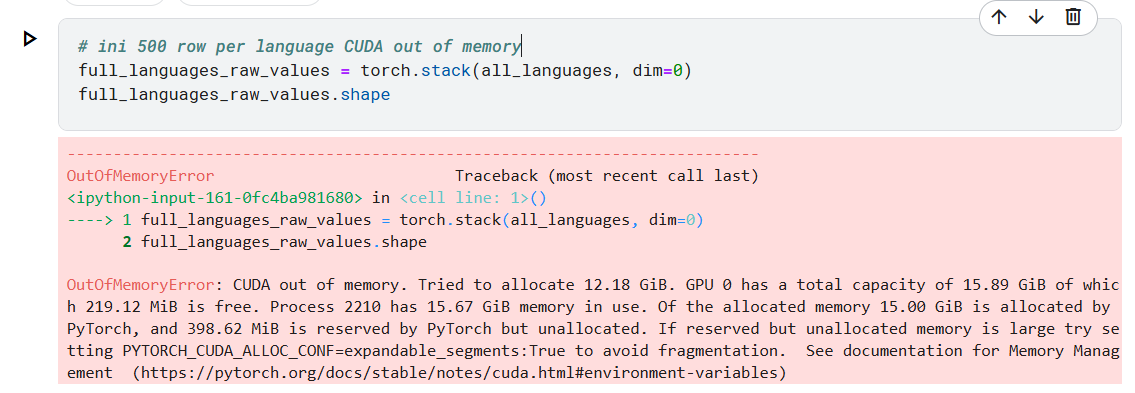

In [170]:
len(all_languages)

28

In [166]:
# Move each tensor to CPU before stacking
cpu_languages = [lang.cpu() for lang in all_languages]

# Stack on CPU
full_languages_raw_values = torch.stack(cpu_languages, dim=0)
print(full_languages_raw_values.shape)


torch.Size([28, 2, 500, 116736])


In [167]:
torch.save(full_languages_raw_values, "massive_500_qwen05_neuron_raw_values.pt")

In [ ]:
full_languages_raw_values = torch.load("massive_qwen05_neuron_raw_values.pt")

In [168]:
full_languages_raw_values.shape

torch.Size([28, 2, 500, 116736])

### satuin semua jadi kelas 
blm selesai


In [ ]:
class NeuronActValues:
    def __init__(self, model_name, device):
        self.raw_values_avg_tokens = {}
        self.raw_values_last_token = {}
        self.clean_hooks()
        

    def save_raw_vals_to_dict(name, dictname, savees):
    if not name in dictname:
        dictname[name] = savees
    else:
        dictname[name] = torch.cat([dictname[name], savees], dim=0)
    
    def clean_hooks():
        for i in range(len(infer_model.model.model.layers)):
            mlp = infer_model.model.model.layers[i].mlp
            mlp.act_fn._forward_hooks.clear()
    
    def get_activation_mlp(name): 
        """
            name (str): buat namain layer
            is_averaged_tokens (boolean): true if avergaed across tokens, else get the last token
        """
        def hook_fn(module, input, output):
            global raw_values_avg_tokens
            global raw_values_last_token
            # print(f"Layer: {name}, output Shape: {output.shape}")
            # print("Output", output)
            # output is always (batch size, dim_neuron_in_a_layer)
            # if is_averaged_tokens: # simpen average value across tokens
            avg_output = output.float().mean(dim=1) 
            save_raw_vals_to_dict(name, raw_values_avg_tokens, avg_output)
            # else:
            last_output = output.float()[:, -1,:] # simpen the last token
            save_raw_vals_to_dict(name, raw_values_last_token, last_output)
            
            
        return hook_fn
    
    def concat_neuron_layers(raw_values_avg_tokens, raw_values_last_token):
        full_raw_values_avg_tokens = list(raw_values_avg_tokens.values())[0]
        full_raw_values_last_token = list(raw_values_last_token.values())[0]
        
        # print(full_raw_values_avg_tokens.shape)
        # print(full_raw_values_last_token.shape)
        for i in list(raw_values_avg_tokens.values())[1:]:
            # print(i.shape)
            full_raw_values_avg_tokens = torch.cat([full_raw_values_avg_tokens, i], dim=-1)
        for i in list(raw_values_last_token.values())[1:]:
            full_raw_values_last_token = torch.cat([full_raw_values_last_token, i], dim=-1)
        # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
        return full_raw_values_avg_tokens, full_raw_values_last_token
    
    
    def merge_avg_last(full_raw_values_avg_tokens, full_raw_values_last_token):
        # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
        full_raw_values = torch.stack((full_raw_values_avg_tokens, full_raw_values_last_token), dim=0)
        return full_raw_values
    






### Pairing antar language

#### Kesamaan index neuron yang teraktivasi.
- Neuron yang teraktivasi -> yang actv. valuenya di atas 0
- 

In [173]:
languages_52 = torch.load("massive_qwen05_neuron_raw_values.pt")
languages_52.shape

<ipython-input-173-0238aecf2e23>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  languages_52 = torch.load("massive_qwen05_neuron_raw_values.pt")


torch.Size([52, 2, 2, 116736])

In [ ]:
languages_52[0] 

#### LAPE

In [185]:
ex = torch.tensor(
    [[[[0, 1, 2, 3],
        [4, 5, 6, 7]]]]
)
ex.transpose(-1,-2)

tensor([[[[0, 4],
          [1, 5],
          [2, 6],
          [3, 7]]]])

In [188]:
# viewnya per neuron
per_neuron = languages_52.transpose(-1,-2)
per_neuron.shape

torch.Size([52, 2, 116736, 2])

In [ ]:
permuted_tensor = tensor.permute(1, 2, 0, 3)

di sini anggap activated neuron (avg token) yang di setiap row di dataset(cuman 2 row) actv valuenya > 0

In [212]:
def get_k_lang_actv_dict(k):
    activation_dict = {}
    
    for i in range (k):
        tensor_lang = per_neuron[i][0]
        rows_with_both_positive = (tensor_lang > 0).all(dim=1)
        
        indices = torch.where(rows_with_both_positive)[0]
        activation_dict[i] = indices
        # indices.shape
        # print(indices.shape)
    return activation_dict

In [226]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def make_heatmap_neuron_overlap(activation_dict, k, with_label=True):    
    # Example dictionary: keys 0-52, values are 1D tensors of activated neuron indices
    # activation_dict = get_k_lang_actv_dict(10)
    
    # Step 1: Create a binary matrix
    max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
    binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
    
    for key, indices in activation_dict.items():
        binary_matrix[key, indices] = 1  # Set activated neurons to 1
    
    # Step 2: Compute overlaps (dot product between rows)
    overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose
    
    # Step 3: Visualize the heatmap
    plt.figure(figsize=(10, 8))
    if with_label:
        sns.heatmap(overlap_matrix.numpy(), annot=True, fmt="d", cmap="YlOrRd", 
                    xticklabels=range(k+1), yticklabels=range(k+1))
    else:
        sns.heatmap(overlap_matrix.numpy(), fmt="d", cmap="YlOrRd",cbar=True)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title("Overlap Heatmap of Activated Neurons")
    plt.show()
    return overlap_matrix

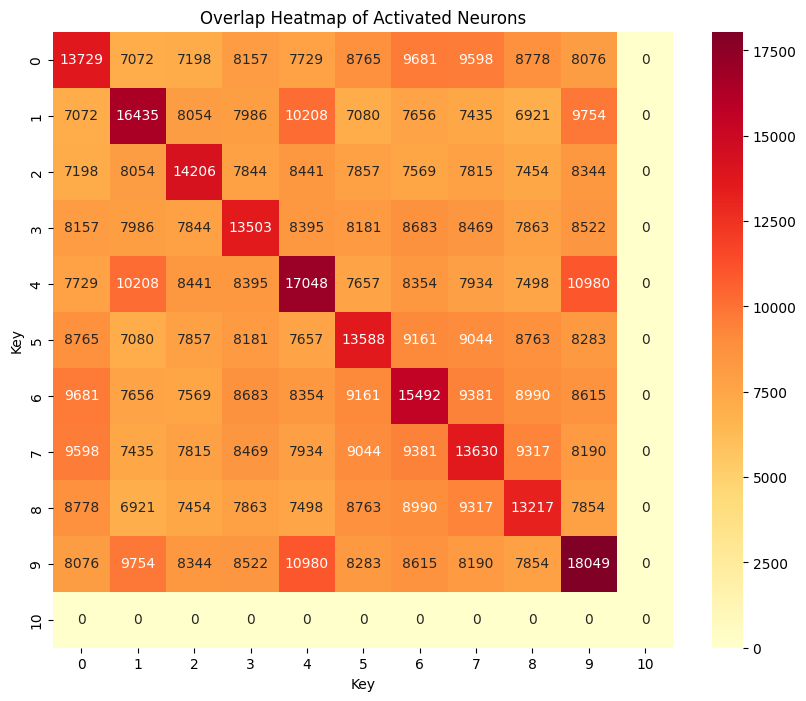

In [228]:
activation_dict = get_k_lang_actv_dict(10)
res_10 = make_heatmap_neuron_overlap(activation_dict, 10, True)

In [229]:
res_10.shape

torch.Size([11, 11])

In [ ]:
rows_with_both_positive = (tensor_lang > 0).all(dim=1)
        
indices = torch.where(rows_with_both_positive)[0]

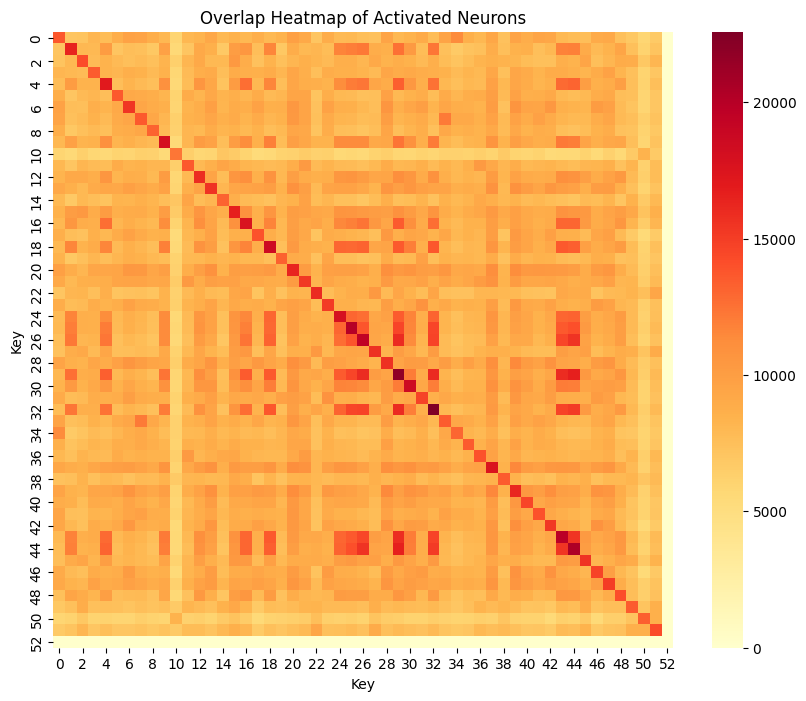

In [216]:
activation_dict = get_k_lang_actv_dict(52)
make_heatmap_neuron_overlap(activation_dict, 52, False)

In [193]:
print(language_dict)

{0: 'af-ZA', 1: 'am-ET', 2: 'ar-SA', 3: 'az-AZ', 4: 'bn-BD', 5: 'ca-ES', 6: 'cy-GB', 7: 'da-DK', 8: 'de-DE', 9: 'el-GR', 10: 'en-US', 11: 'es-ES', 12: 'fa-IR', 13: 'fi-FI', 14: 'fr-FR', 15: 'he-IL', 16: 'hi-IN', 17: 'hu-HU', 18: 'hy-AM', 19: 'id-ID', 20: 'is-IS', 21: 'it-IT', 22: 'ja-JP', 23: 'jv-ID', 24: 'ka-GE', 25: 'km-KH', 26: 'kn-IN', 27: 'ko-KR', 28: 'lv-LV'}


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


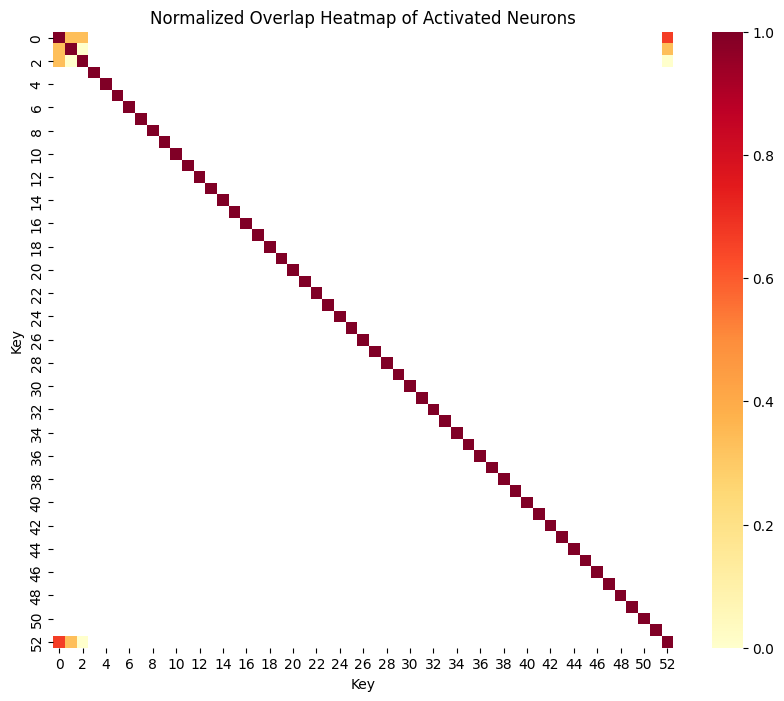

In [221]:
# normalized, tiap kolom (m,n) isinya jumlah overlap neuron dibagi min(m,n)
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Example dictionary: keys 0-52, values are 1D tensors of activated neuron indices
# activation_dict = {
#     0: torch.tensor([1, 3, 5]),
#     1: torch.tensor([2, 3, 6]),
#     2: torch.tensor([1, 4, 7]),
#     # Add more keys and values...
#     52: torch.tensor([3, 5, 8])
# }

# Step 1: Create a binary matrix
max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
binary_matrix = torch.zeros((53, max_neuron_index), dtype=torch.int)  # Initialize binary matrix

for key, indices in activation_dict.items():
    binary_matrix[key, indices] = 1  # Set activated neurons to 1

# Step 2: Compute overlaps (dot product between rows)
overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose

# Step 3: Normalize the overlap matrix
# Compute the number of activated neurons for each key
num_activated_neurons = binary_matrix.sum(dim=1, keepdim=True)

# Normalize by the minimum number of activated neurons between each pair of keys
normalized_overlap_matrix = overlap_matrix / torch.minimum(
    num_activated_neurons, num_activated_neurons.T
)

# Ensure the diagonal is exactly 1 (self-overlap is always 1)
normalized_overlap_matrix.fill_diagonal_(1)

# Step 4: Visualize the normalized heatmap (no labels or annotations)
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_overlap_matrix.numpy(), cmap="YlOrRd", cbar=True, vmin=0, vmax=1)
plt.xlabel("Key")
plt.ylabel("Key")
plt.title("Normalized Overlap Heatmap of Activated Neurons")
plt.show()

In [192]:
tensor = per_neuron[0][0]
rows_with_both_positive = (tensor > 0).all(dim=1)

# Get the indices of such rows
indices = torch.where(rows_with_both_positive)[0]
indices.shape

torch.Size([13729])

In [ ]:
# make a plot per language avged_token

In [189]:
per_neuron.shape

torch.Size([52, 2, 116736, 2])

#### AP

### === end Pairing antar language